<a href="https://colab.research.google.com/github/Kunal-code-u/clustering-analysis/blob/main/ClusteringAssigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📌 Required Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
# 📥 Load Iris Dataset directly from UCI
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv(url, header=None, names=col_names)

# Drop the label column
X = df.drop('class', axis=1)

In [3]:
# 📊 Define Preprocessing Techniques
def preprocess(X, method):
    if method == "none":
        return X.values
    elif method == "normalize":
        return StandardScaler().fit_transform(X)
    elif method == "transform":
        return PowerTransformer().fit_transform(X)
    elif method == "pca":
        return PCA(n_components=2).fit_transform(StandardScaler().fit_transform(X))
    elif method == "t+n":
        return StandardScaler().fit_transform(PowerTransformer().fit_transform(X))
    elif method == "t+n+pca":
        return PCA(n_components=2).fit_transform(
            StandardScaler().fit_transform(
                PowerTransformer().fit_transform(X)
            )
        )
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")

In [5]:
# 📌 Clustering Methods
clustering_algos = {
    "KMeans": lambda c: KMeans(n_clusters=c, n_init=10, random_state=42),
    "Hierarchical": lambda c: AgglomerativeClustering(n_clusters=c),
    "MeanShift": lambda _: MeanShift()
}
# 📌 Parameters
preprocessing_methods = ["none", "normalize", "transform", "pca", "t+n", "t+n+pca"]
clusters = [2, 3, 4]


In [7]:
# 📊 Collect Results
results = []
for method in preprocessing_methods:
    X_proc = preprocess(X, method)
    for algo_name, algo_fn in clustering_algos.items():
        for c in clusters:
            if algo_name == "MeanShift" and method in ["transform", "t+n", "t+n+pca"]:
                continue  # skip unstable cases
            try:
                model = algo_fn(c)
                labels = model.fit_predict(X_proc)
                sil = silhouette_score(X_proc, labels)
                ch = calinski_harabasz_score(X_proc, labels)
                db = davies_bouldin_score(X_proc, labels)
                results.append([algo_name, method, c, sil, ch, db])
            except Exception as e:
                results.append([algo_name, method, c, np.nan, np.nan, np.nan])

In [14]:
# 📋 Build DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Algorithm","Preprocessing","Clusters","Silhouette","Calinski-Harabasz","Davies-Bouldin"]
).sort_values(["Algorithm","Preprocessing","Clusters"]).reset_index(drop=True)

# Save to CSV
results_df.to_csv("iris_clustering_results.csv", index=False)
print("Results saved to iris_clustering_results.csv")
print(results_df)

Results saved to iris_clustering_results.csv
       Algorithm Preprocessing  Clusters  Silhouette  Calinski-Harabasz  \
0   Hierarchical          none         2    0.686393         501.924864   
1   Hierarchical          none         3    0.554097         556.841122   
2   Hierarchical          none         4    0.488740         513.772164   
3   Hierarchical     normalize         2    0.575387         237.825904   
4   Hierarchical     normalize         3    0.445540         220.260437   
5   Hierarchical     normalize         4    0.399326         198.730315   
6   Hierarchical           pca         2    0.613037         280.124507   
7   Hierarchical           pca         3    0.510294         283.107423   
8   Hierarchical           pca         4    0.460304         253.908112   
9   Hierarchical           t+n         2    0.580863         245.120770   
10  Hierarchical           t+n         3    0.477877         223.370404   
11  Hierarchical           t+n         4    0.426466   

In [12]:
# 📊 Plotting function
def plot_metrics(df, metric, fname):
    plt.figure(figsize=(10,6))
    for algo in df["Algorithm"].unique():
        sub = df[df["Algorithm"] == algo]
        for method in sub["Preprocessing"].unique():
            ss = sub[sub["Preprocessing"] == method]
            plt.plot(
                ss["Clusters"], ss[metric],
                marker='o', label=f"{algo}-{method}"
            )
    plt.title(f"{metric} vs Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize="small")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

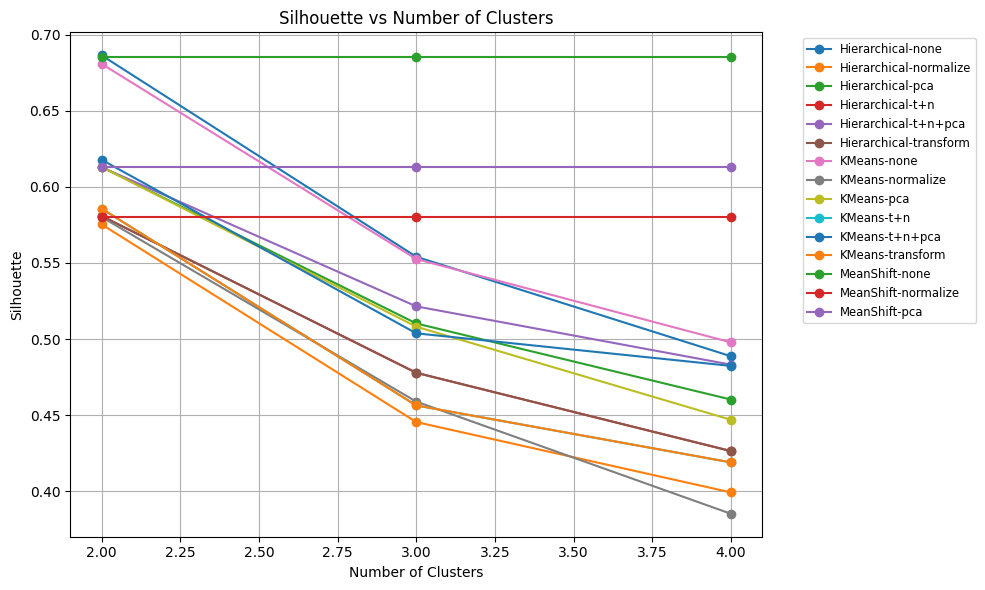

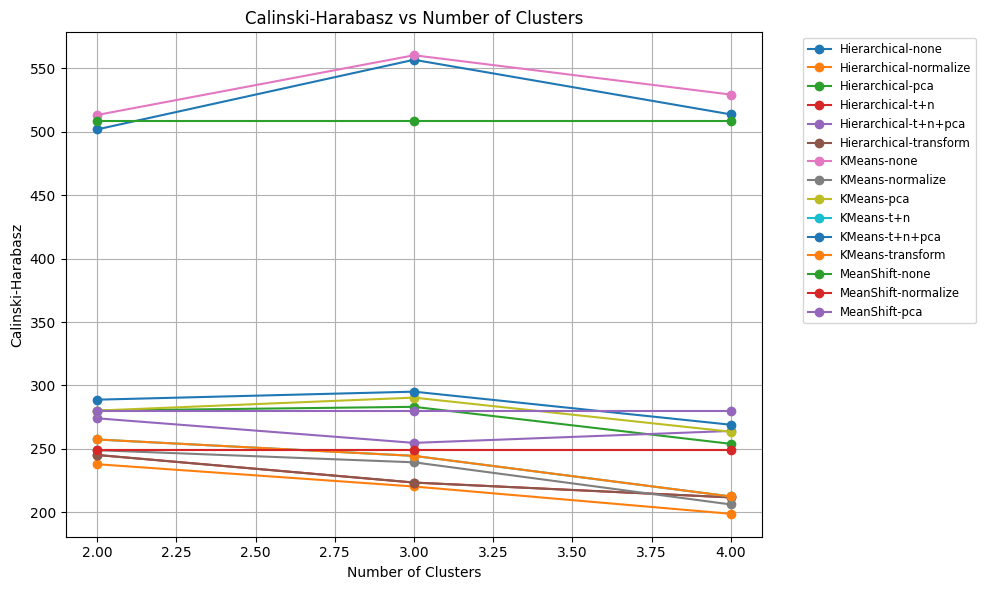

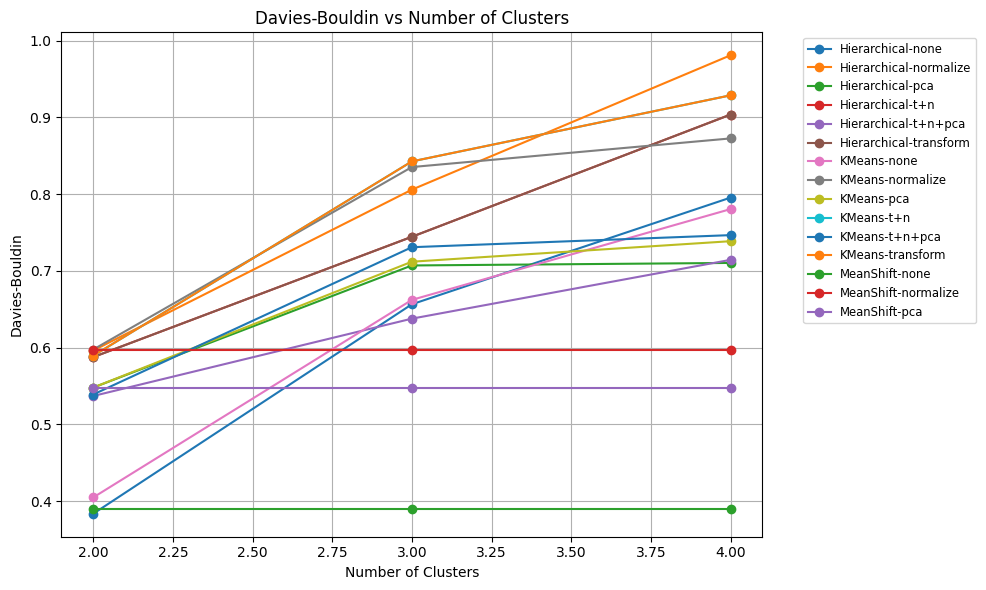

In [13]:
# 📈 Generate and save the three metric plots
plot_metrics(results_df, "Silhouette", "iris_silhouette.png")
plot_metrics(results_df, "Calinski-Harabasz", "iris_calinski_harabasz.png")
plot_metrics(results_df, "Davies-Bouldin", "iris_davies_bouldin.png")